In [1]:
library(SPARSim)
library(dplyr)
library(Seurat)
library(qusage)
library(stringr)
library(ggplot2)
library('biomaRt')

sessionInfo()


Attache Paket: 'dplyr'


Die folgenden Objekte sind maskiert von 'package:stats':

    filter, lag


Die folgenden Objekte sind maskiert von 'package:base':

    intersect, setdiff, setequal, union


Attaching SeuratObject

Lade n"otiges Paket: limma



R version 4.2.2 (2022-10-31)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] biomaRt_2.54.0     ggplot2_3.4.0      stringr_1.5.0      qusage_2.32.0     
[5] limma_3.54.0       SeuratObject_4.1.3 Seurat_4.3.0       dplyr_1.0.10      
[9] SPARSim_0.9.5     

loaded via a namespace (and not attached):
  [1] uuid_1.1-0             BiocFileCache_2.6.0    plyr_1.8.8            
  [4] igraph_1.3.5           repr_1.1.5             lazyeval_0.2.2        
  [7] sp_1.5-1               splines_4.2.2          listenv_0.9.0         
 [10] scattermore_0.8        GenomeInfoDb_1.34.6    digest_0.6.31         
 [13] htmltools_0.5.4       

In [3]:
#devtools::install_gitlab("sysbiobig/sparsim", build_opts = c("--no-resave-data", "--no-manual"), build_vignettes = TRUE)
#install.packages(c("Seurat", "deplyr", "stringr"))
#BiocManager::install(c("qusage", "edgeR", "mclust", "scater", "scran"))

In [2]:
use_file = "go_human.bp.gmt"

#if( ! file.exists("ReactomePathways.gmt")){
#      #download_and_unzip("https://reactome.org/download/current/ReactomePathways.gmt.zip", ".", "ReactomePathways.gmt.zip", ".")
#      temp <- tempfile()
#      download.file("https://reactome.org/download/current/ReactomePathways.gmt.zip",temp)
#      Reactome <- qusage::read.gmt(unzip(temp, exdir = "./"))
#      unlink(temp)
#}

pathways <- qusage::read.gmt(use_file)



In [3]:
grep("receptor", names(pathways), value=T)

[1] "G protein-coupled receptor signaling pathway"                                                                                            
  [2] "transmembrane receptor protein serine/threonine kinase signaling pathway"                                                                
  [3] "T cell receptor signaling pathway"                                                                                                       
  [4] "B cell receptor signaling pathway"                                                                                                       
  [5] "auditory receptor cell stereocilium organization"                                                                                        
  [6] "positive regulation of T cell receptor signaling pathway"                                                                                
  [7] "regulation of postsynaptic membrane neurotransmitter receptor levels"                                                                    
  [8] "serotonin receptor signaling pathway"                                                                                                    
  [9] "negative regulation of intracellular estrogen receptor signaling pathway"                                                                
 [10] "negative regulation of retinoic acid receptor signaling pathway"                                                                         
 [11] "sphingosine-1-phosphate receptor signaling pathway"                                                                                      
 [12] "negative regulation of toll-like receptor 2 signaling pathway"                                                                           
 [13] "negative regulation of toll-like receptor 4 signaling pathway"                                                                           
 [14] "regulation of AMPA glutamate receptor clustering"                                                                                        
 [15] "regulation of AMPA receptor activity"                                                                                                    
 [16] "gamma-aminobutyric acid receptor clustering"                                                                                             
 [17] "regulation of postsynaptic neurotransmitter receptor activity"                                                                           
 [18] "regulation of GABA-A receptor activity"                                                                                                  
 [19] "G protein-coupled receptor catabolic process"                                                                                            
 [20] "inner ear auditory receptor cell differentiation"                                                                                        
 [21] "vestibular receptor cell development"                                                                                                    
 [22] "inner ear receptor cell development"                                                                                                     
 [23] "inner ear receptor cell stereocilium organization"                                                                                       
 [24] "intracellular receptor signaling pathway"                                                                                                
 [25] "Fc-gamma receptor signaling pathway involved in phagocytosis"                                                                            
 [26] "endothelin receptor signaling pathway"                                                                                                   
 [27] "toll-like receptor 2 signaling pathway"                                                                                                  
 [28] "toll-like receptor 4 signaling pathway"                                         

In [4]:
#c("Tung_param_preset", "Camp_param_preset", "Engel_param_preset", "Chu_param_preset", "Horning_param_preset", "Bacher_param_preset", "Brain_10X_param_preset", "T_10X_param_preset", "PBMC_10X_param_preset", "Zheng_param_preset", "Macosko_param_preset", "Saunders_param_preset")
# should match reactome names
data("PBMC_10X_param_preset")
intensity= PBMC_10X_param_preset[[1]]$intensity

genes_df=data.frame(names=names(intensity))

mart <- useDataset("hsapiens_gene_ensembl", useMart("ensembl"))
G_list <- getBM(filters= "ensembl_gene_id", attributes= c("ensembl_gene_id","hgnc_symbol"),values=genes_df$name,mart= mart)

genes_df= merge(genes_df,G_list,by.x="names",by.y="ensembl_gene_id",all.x=TRUE)

genes_df$hgnc_symbol[duplicated(genes_df$hgnc_symbol)] <- NA

genes_df[is.na(genes_df$hgnc_symbol),]$hgnc_symbol=paste0("NA_",1:sum(is.na(genes_df$hgnc_symbol)))

genes=genes_df$hgnc_symbol
names(intensity)=genes

keepIndices = grep("^NA_", names(intensity), invert=T)
intensity = intensity[ keepIndices ]
variability = PBMC_10X_param_preset[[1]]$variability[ keepIndices ]

n_genes=length(genes)
library_size=PBMC_10X_param_preset[[1]]$lib_size  * 10 ### here lib factor
n_cells=length(library_size)
genes=names(intensity)

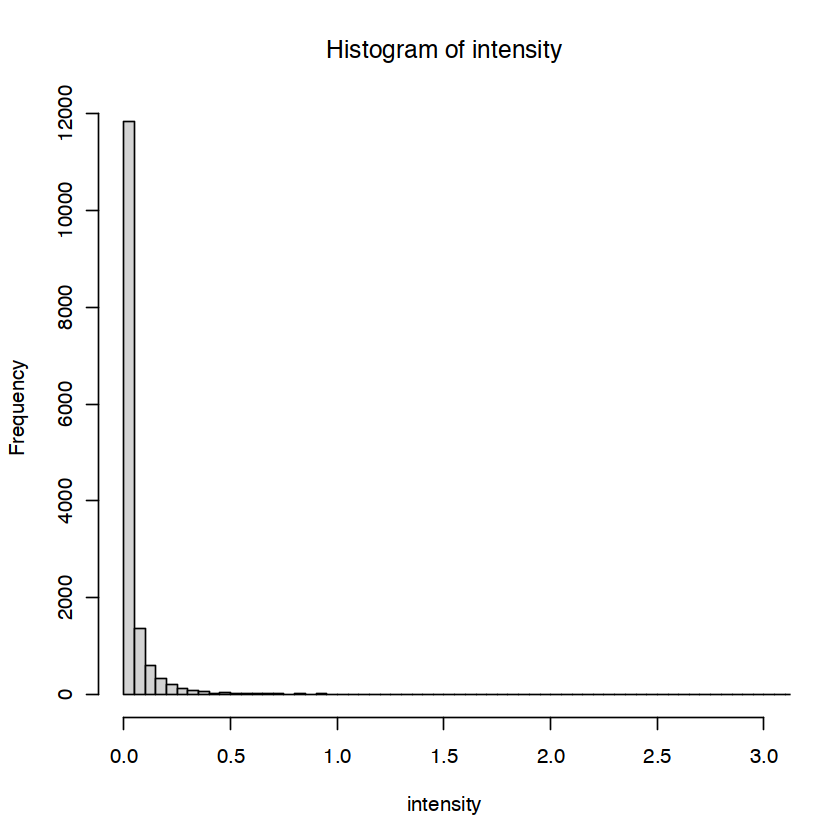

In [5]:
hist(intensity, xlim = c(0, 3), breaks=2000)

In [6]:
highIntensityGenes = names(intensity[intensity > 0.05])

In [7]:
keepPWs = c()

for (pw in names(pathways))
{
    numGenes = length(pathways[[pw]])
    numHighIntensityGenes = length(intersect(highIntensityGenes, pathways[[pw]]))

    highIntensityRatio = numHighIntensityGenes / numGenes

    if ((numGenes > 1) && (highIntensityRatio > 0.5))
    {
        print(paste(pw, numGenes, numHighIntensityGenes))
        keepPWs = c(keepPWs, pw)
    }
}

[1] "endoplasmic reticulum-plasma membrane tethering 5 3"
[1] "nucleotide-binding oligomerization domain containing 2 signaling pathway 9 5"
[1] "lysine catabolic process 5 3"
[1] "positive regulation of T cell activation via T cell receptor contact with antigen bound to MHC molecule on antigen presenting cell 3 2"
[1] "wound healing involved in inflammatory response 2 2"
[1] "nucleotide-binding oligomerization domain containing 1 signaling pathway 3 2"
[1] "positive regulation of nucleotide-binding oligomerization domain containing 1 signaling pathway 3 2"
[1] "proteasome regulatory particle assembly 3 3"
[1] "negative regulation of apoptotic DNA fragmentation 2 2"
[1] "regulation of protein autophosphorylation 4 3"
[1] "catabolic process 3 2"
[1] "isoprenoid metabolic process 3 2"
[1] "zinc ion homeostasis 2 2"
[1] "amino acid catabolic process 5 3"
[1] "negative regulation of myosin-light-chain-phosphatase activity 5 3"
[1] "negative regulation of bicellular tight junction assembly 

In [8]:
keepPWs[1:10]

[1] "endoplasmic reticulum-plasma membrane tethering"                                                                                   
 [2] "nucleotide-binding oligomerization domain containing 2 signaling pathway"                                                          
 [3] "lysine catabolic process"                                                                                                          
 [4] "positive regulation of T cell activation via T cell receptor contact with antigen bound to MHC molecule on antigen presenting cell"
 [5] "wound healing involved in inflammatory response"                                                                                   
 [6] "nucleotide-binding oligomerization domain containing 1 signaling pathway"                                                          
 [7] "positive regulation of nucleotide-binding oligomerization domain containing 1 signaling pathway"                                   
 [8] "proteasome regulatory particle assembly"                                                                                           
 [9] "negative regulation of apoptotic DNA fragmentation"                                                                                
[10] "regulation of protein autophosphorylation"

In [9]:
#Set states
states=c("timepoint01","timepoint02","timepoint03","timepoint04")

num_pws_per_state=10

state2pw = list()
state2genes = list()
state2count = list()

for (state in states)
{
    state2count[[state]] = 0
}

for (pw in keepPWs)
{
    #print(pw)
    pwGenes = pathways[[pw]]
    pwGenes = intersect(pwGenes, names(intensity))
    #print(pwGenes)

    intersections = list()
    
    for (state in states)
    {
        if (state %in% names(state2genes))
        {
            commonGenes = intersect(pwGenes, state2genes[[state]])
            if (length(commonGenes) > 0)
            {
                intersections[[state]] = length(commonGenes)
            }
        }
    }

    curstate = NULL
    if (length(names(intersections)) == 1)
    {
        #print("One Intersection")
        nextstate = names(intersections)[1]

        if (state2count[[nextstate]] < num_pws_per_state)
        {
            curstate = nextstate
        }

    } else if (length(names(intersections)) == 0)
    {

        #print("No Intersection")
        for (state in states)
        {
            if (state2count[[state]] < num_pws_per_state)   
            {
                curstate = state
                break       
            }
        }

    }

    #print(curstate)

    if (!is.null(curstate))
    {
        #print(curstate)
        if (curstate %in% names(state2genes))
        {
            #print("Add case")
            state2genes[[curstate]] = c(state2genes[[curstate]], pwGenes)
            state2pw[[curstate]] = c(state2pw[[curstate]], pw)
            state2count[[curstate]] = state2count[[curstate]] + 1
        } else {
            #print("init case")
            state2genes[[curstate]] = c(pwGenes)
            state2pw[[curstate]] = c(pw)
            state2count[[curstate]] = state2count[[curstate]] + 1
        }
        

    }

}

print(state2pw)

$timepoint01
 [1] "endoplasmic reticulum-plasma membrane tethering"                                                                                   
 [2] "nucleotide-binding oligomerization domain containing 2 signaling pathway"                                                          
 [3] "lysine catabolic process"                                                                                                          
 [4] "positive regulation of T cell activation via T cell receptor contact with antigen bound to MHC molecule on antigen presenting cell"
 [5] "wound healing involved in inflammatory response"                                                                                   
 [6] "nucleotide-binding oligomerization domain containing 1 signaling pathway"                                                          
 [7] "positive regulation of nucleotide-binding oligomerization domain containing 1 signaling pathway"                                   
 [8] "proteasome regu

            Length Class  Mode
timepoint01 6      -none- list
timepoint02 6      -none- list
timepoint03 6      -none- list
timepoint04 6      -none- list
[1] "Changing genes:"


timepoint01  timepoint02  timepoint03  timepoint04 
KDM1A    0.8406277174 0.8406277174 4.203139e-01 4.203139e-01
MARK4    0.0722477008 0.5779816063 5.779816e-01 7.224770e-02
AASS     0.0561145535 0.0561145535 2.244582e-01 2.244582e-01
FOXP3    0.0600159432 0.4801275457 4.801275e-01 6.001594e-02
RC3H2    0.3267484087 2.6139872693 2.613987e+00 3.267484e-01
ROCK1    0.0598846654 3.8326185886 3.832619e+00 5.988467e-02
PPP2R5B  0.9326515839 0.9326515839 3.730606e+00 3.730606e+00
RORA     1.3212650026 1.3212650026 6.606325e-01 6.606325e-01
TRIP13   0.0579246176 0.0579246176 2.896231e-02 2.896231e-02
TBX21    0.0022825022 0.0182600180 1.826002e-02 2.282502e-03
WDR62    0.1567466128 1.2539729020 1.253973e+00 1.567466e-01
BAX      0.1248077301 0.1248077301 6.240387e-02 6.240387e-02
AURKA    0.1247693550 0.9981548396 9.981548e-01 1.247694e-01
PSMD5    0.6826691735 0.6826691735 2.730677e+00 2.730677e+00
JAK2     0.0001876151 0.0001876151 9.380755e-05 9.380755e-05
EIF3L    0.1217136884 0.1217136884 6.085684e-02 6.085684e-02
HMOX1    0.0507318815 0.0507318815 2.029275e-01 2.029275e-01
EIF3D    0.0080430277 0.0080430277 4.021514e-03 4.021514e-03
NFKBIA   0.0578674212 0.0578674212 9.258787e-01 9.258787e-01
USP14    0.4379990593 0.4379990593 2.189995e-01 2.189995e-01
SMAD7    0.0019201454 0.0153611634 1.536116e-02 1.920145e-03
PSMD10   0.0827405774 0.0827405774 3.309623e-01 3.309623e-01
CRYM     0.0566025948 0.0566025948 2.264104e-01 2.264104e-01
EEF2K    0.0575210886 0.0575210886 2.300844e-01 2.300844e-01
BCKDK    0.0099637937 0.0797103497 7.971035e-02 9.963794e-03
SLC30A4  0.0658357038 0.5266856302 5.266856e-01 6.583570e-02
RIPK2    0.0101813486 0.0101813486 1.629016e-01 1.629016e-01
IKBKB    0.0394181096 2.5227590171 2.522759e+00 3.941811e-02
IL4I1    1.2387962332 9.9103698657 9.910370e+00 1.238796e+00
SGTA     0.6071819107 0.6071819107 3.035910e-01 3.035910e-01
<U+22EE>        <U+22EE>     <U+22EE>     <U+22EE>     <U+22EE>    
ZC3H12A  6.946124e-02 5.556900e-01 0.5556899572 0.0694612447
NIPBL    5.191761e-01 5.191761e-01 0.2595880523 0.2595880523
PTER     7.536235e-03 6.028988e-02 0.0602898794 0.0075362349
SMAD3    9.193163e-01 9.193163e-01 0.4596581306 0.4596581306
NOD2     1.263704e-01 1.263704e-01 0.5054815423 0.5054815423
TMEM150A 6.354015e-02 5.083212e-01 0.5083211982 0.0635401498
LGALS9   5.702926e-02 5.702926e-02 0.2281170380 0.2281170380
ATF5     1.082332e-01 8.658653e-01 0.8658652800 0.1082331600
DFFB     1.003891e-01 1.003891e-01 0.4015563304 0.4015563304
CES2     7.441822e-02 5.953457e-01 0.5953457456 0.0744182182
RELA     2.144599e-04 2.144599e-04 0.0008578395 0.0008578395
MOB1B    7.267066e-02 7.267066e-02 0.2906826301 0.2906826301
GATD1    1.086271e-01 8.690167e-01 0.8690167274 0.1086270909
LACC1    8.120264e-01 8.120264e-01 3.2481057454 3.2481057454
PIPOX    5.259898e-05 5.259898e-05 0.0002103959 0.0002103959
TBX1     2.476727e-01 2.476727e-01 0.0619181857 0.0619181857
PRKN     2.676011e-01 2.140809e+00 2.1408089461 0.2676011183
HGS      5.764523e-02 4.611618e-01 0.4611618382 0.0576452298
INSIG1   1.761394e-01 1.761394e-01 0.0880697056 0.0880697056
HYKK     8.156650e-01 8.156650e-01 3.2626599546 3.2626599546
SVIP     1.613608e-01 1.613608e-01 0.0806804242 0.0806804242
L3MBTL3  1.034144e-01 1.034144e-01 0.0517071766 0.0517071766
PLPP6    1.716303e-02 1.373042e-01 0.1373042358 0.0171630295
PLXNA4   5.798441e-01 5.798441e-01 0.2899220650 0.2899220650
CCNL2    3.241485e-02 2.593188e-01 0.2593188383 0.0324148548
TNF      1.106476e-01 7.081449e+00 7.0814491160 0.1106476424
IRGM     5.960499e-02 5.960499e-02 0.2384199670 0.2384199670
HLA-DMB  3.020037e-02 3.020037e-02 0.1208014861 0.1208014861
LYN      1.067313e-03 1.067313e-03 0.0005336566 0.0005336566
CHMP4A   5.992795e-01 4.794236e+00 4.7942357068 0.5992794633

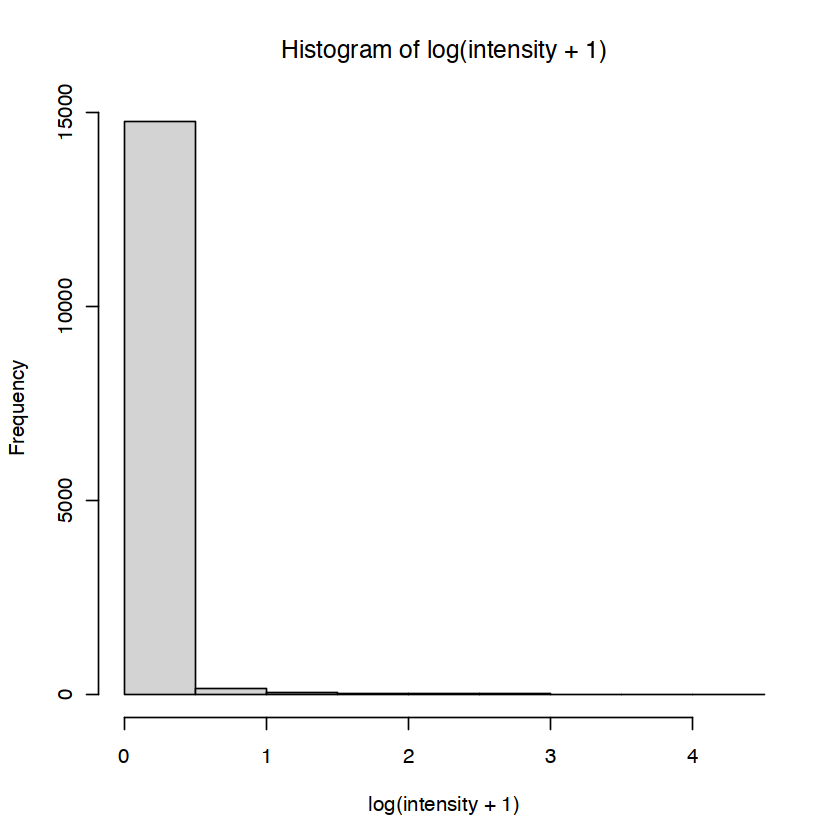

In [10]:


hist(log(intensity+1))

#Set scaling for changes
#Here for every state a scaling factor can be set which will be applied to every gene in the geneset
changes=list()

set.seed(1) 




trends=list(c(1,1,4,4),c(1,8,8,1),c(2,2,1,1), c(3,3,3,3))

for(i in 1:length(trends)){

  statename = names(state2pw)[i]
  
  for (pw in state2pw[[statename]])
  {
    changes[[pw]] = unlist(trends[i])
  }
}

#changes[["Glycerophospholipid catabolism"]]=c(1,1,4,4)
#changes[["Glutathione synthesis and recycling"]]=c(1,1,4,4)
#changes[["G1 Phase"]]=c(1,8,8,1)
#changes[["Glutathione synthesis and recycling"]]=c(1,8,8,1)
#changes[["Formation of apoptosome"]]=c(1,1,.25,.25)
#changes[["Downstream signaling of activated FGFR4"]]=c(1,1,.25,.25)
changes_df=data.frame(Reduce(rbind, changes))
rownames(changes_df)=names(changes)
colnames(changes_df)=states
write.table(changes_df,file = "simulated_changingPathways_random.tsv",sep="\t",row.names = TRUE,col.names=TRUE,quote = FALSE)

parameter_list=lapply(states,function(x)
  list(intensity=intensity,variability=variability,library_size=library_size,feature_names=genes,sample_names=paste0(x,"-Cell",1:n_cells),condition_name=x)
  )
names(parameter_list)=states


for(c in names(changes)){
  scaling=changes[[c]]
  geneset=intersect(pathways[[c]], names(intensity))
  for(i in 1:length(parameter_list)){
    name_i=names(parameter_list)[i]
    #hist(log10(parameter_list[[i]]$intensity[genes %in% geneset]+1))
    parameter_list[[i]]$intensity[names(intensity) %in% geneset]=parameter_list[[i]]$intensity[names(intensity) %in% geneset]*scaling[i]
  }
}

print(summary(parameter_list))
intensity_matrix=do.call(cbind,lapply(parameter_list,function(x)x$intensity))
print("Changing genes:")
intensity_matrix[unlist(apply(intensity_matrix,1, sd, na.rm = TRUE))!=0, ]

In [11]:
dim(intensity)
dim(parameter_list[[1]]$variability)
dim(parameter_list[[2]]$intensity)
dim(parameter_list[[3]]$intensity)
dim(parameter_list[[4]]$intensity)

[1] 15072

[1] 15072

[1] 15072

[1] 15072

[1] 15072

In [12]:
param_per_condition=lapply(parameter_list,function(x)
  

  SPARSim_create_simulation_parameter(
                                  intensity = x$intensity, 
                                  variability = x$variability, 
                                  library_size = x$library_size,
                                  feature_names = x$feature_names, 
                                  sample_names =x$sample_names, 
                                  condition_name = x$condition_name)
  
  )
sim_result <- SPARSim_simulation(dataset_parameter = param_per_condition)


condition_vector=sapply(stringr::str_split(colnames(sim_result$count_matrix),"-"), "[[", 1)

Number of experimental conditions:  4 
Number of genes:  15072 
Number of cells:  21676 
Setting gene expression intensity...  
Setting gene expression variability ...  
Simulating biological variability ...  
Simulating technical variability ...  


Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
"All cells have the same value of percent.mt."
Warning message in cor(x = data[, 1], y = data[, 2]):
"Standardabweichung ist Null"


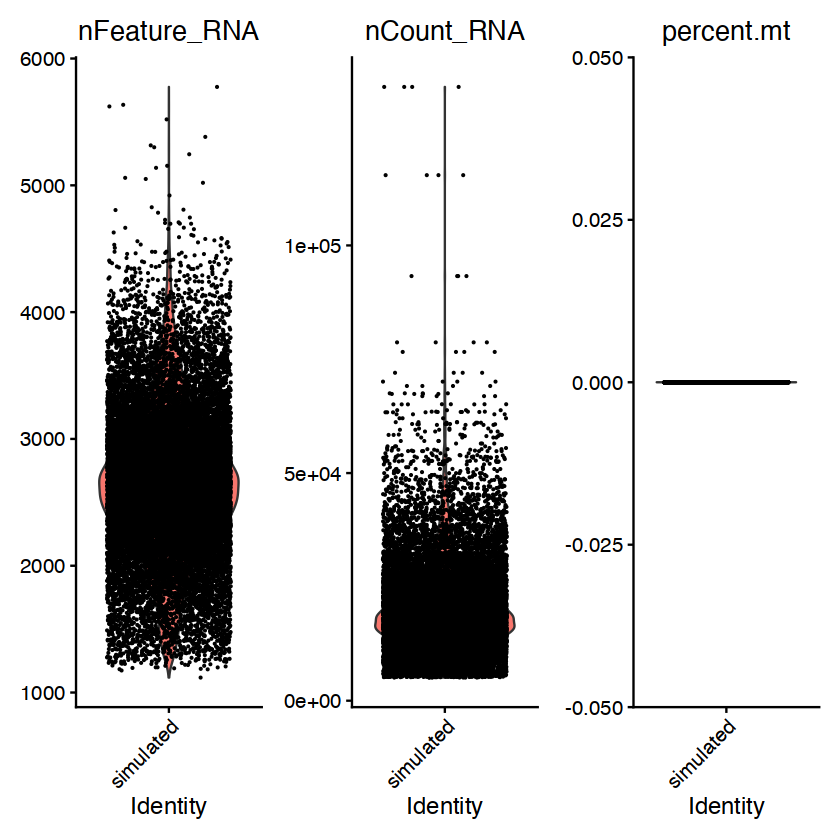

When using repel, set xnudge and ynudge to 0 for optimal results



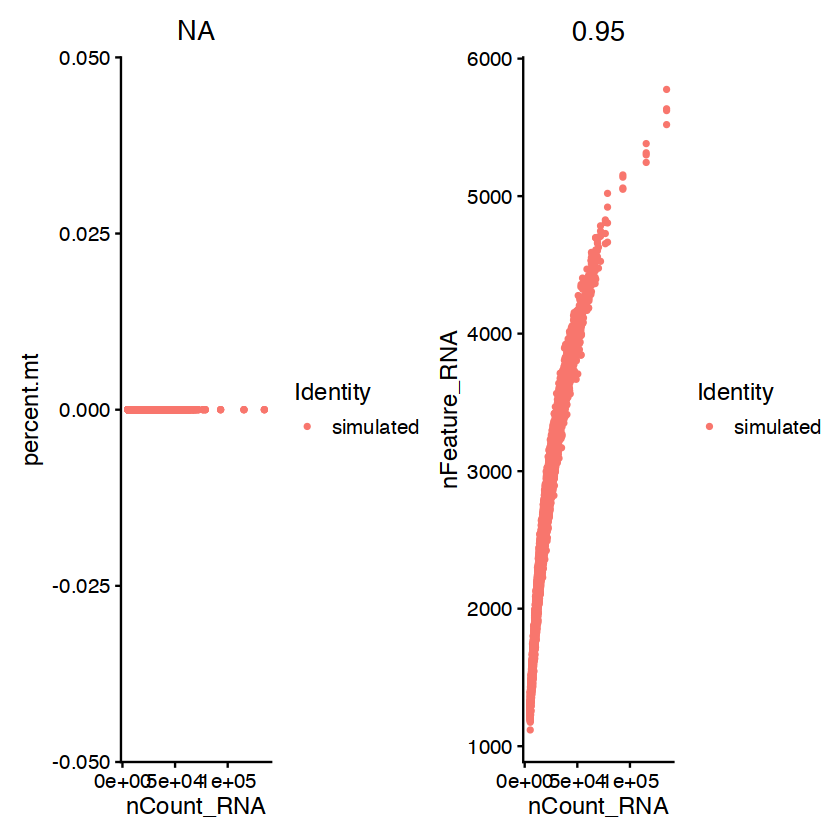

Centering and scaling data matrix

PC_ 1 
Positive:  IKBKB, ROCK1, ROCK2, RC3H2, ETFB, PRKN, PARK7, TNF, SNX3, IL4I1 
	   RC3H1, ATF5, MARK4, MCPH1, FNBP1L, GGPS1, PHYH, TMEM150A, SLC30A4, ZBTB7B 
	   HGS, ZC3H12A, ETFA, CHMP4A, AURKA, PLPP6, IL4, NCKAP1L, CCNL1, CHMP2A 
Negative:  CD81, DCAKD, LACC1, MGA, CDH4, PPP2R5B, C17orf99, TLR4, LGALS9, SPATS2 
	   GARIN4, HLA.DMB, GRAMD1B, KBTBD11, PITPNM2.AS1, EDDM13, WDR27, PIDD1, ZNF385D, REXO2 
	   HYKK, CNPY2, RPL41, PRICKLE1, LRP5, FAM168B, GIMAP8, RWDD2B, DDHD1.DT, COL1A1 
PC_ 2 
Positive:  TBX1, TPH1, RORA, NIPBL, SGTA, INSIG1, EIF3L, L3MBTL3, C22orf42, RIMKLB 
	   POLR2G, YIF1A, PPP3CC, UNG, MT.CO1, DUS1L, TCOF1, LILRB4, KCTD12, GPRASP2 
	   ZNF217, NDUFS1, PI4KB, MCAM, GJB7, EEA1, UMODL1, KLF2, MAIP1, RERE 
Negative:  TLR4, CD81, LACC1, PPP2R5B, HYKK, ESYT1, RIPK2, IRGM, NFKBIA, DFFB 
	   LGALS9, CRYM, PSMD10, HLA.DMB, SLC46A2, SLC15A4, VAPB, OTULIN, DFFA, LRATD2 
	   FZD9, ZCCHC2, KIAA0408, SLC25A34, EIF2AK3.DT, B3GALT2, RHBDD3, KLH

PC_ 1 
Positive:  IKBKB, ROCK1, ROCK2, RC3H2, ETFB 
Negative:  CD81, DCAKD, LACC1, MGA, CDH4 
PC_ 2 
Positive:  TBX1, TPH1, RORA, NIPBL, SGTA 
Negative:  TLR4, CD81, LACC1, PPP2R5B, HYKK 
PC_ 3 
Positive:  IFT88, FRMD3, BOLA2B, PPP3CC, ZMYM3 
Negative:  MPI, DUS1L, RBMS2, PTPN23, MARS2 
PC_ 4 
Positive:  UGT8, NCOR1, ATP6V0E1, ZNF415, USP30 
Negative:  C22orf15, HDGFL2, LINC02724, CALHM6, LINC01840 
PC_ 5 
Positive:  ADD2, RPL17, FRAT1, TMEM42, FAM168B 
Negative:  ANP32E, FAM88B, PHLDA3, MT.CO1, CLU 


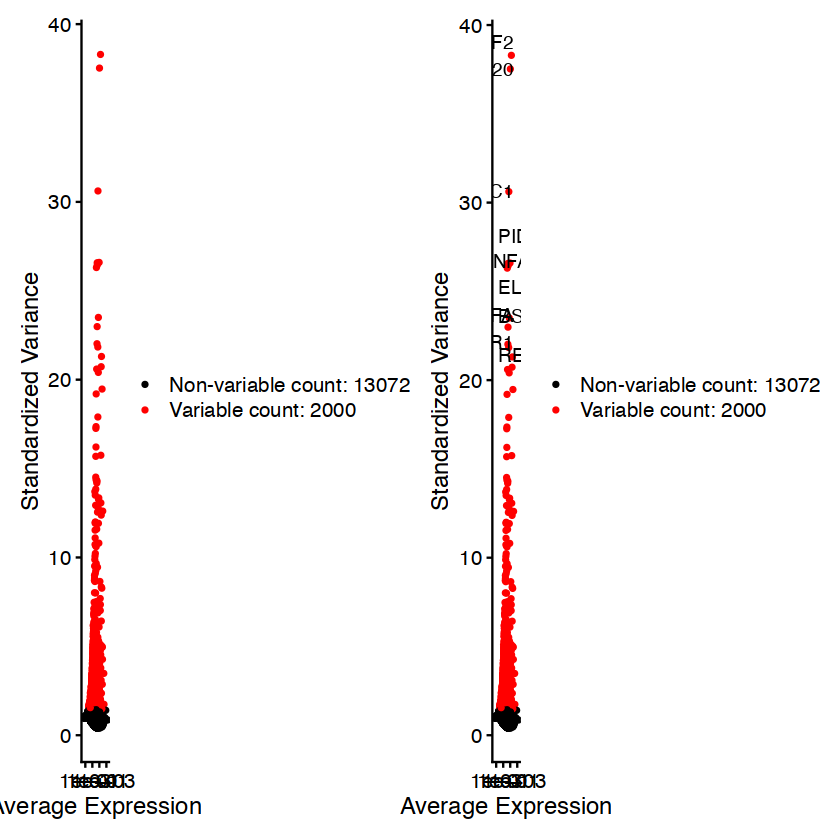

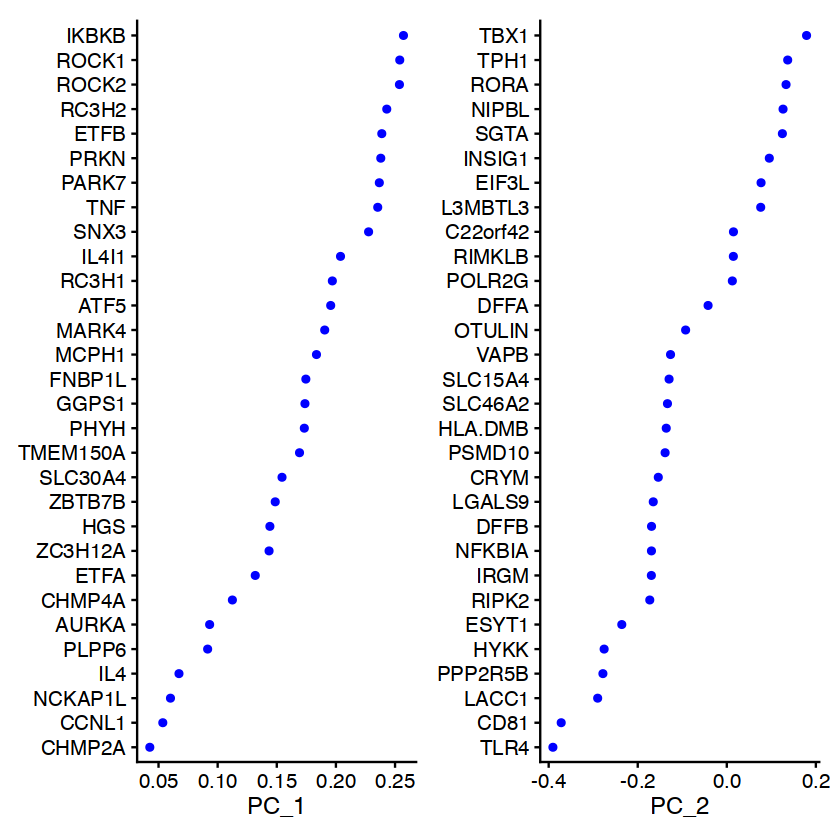

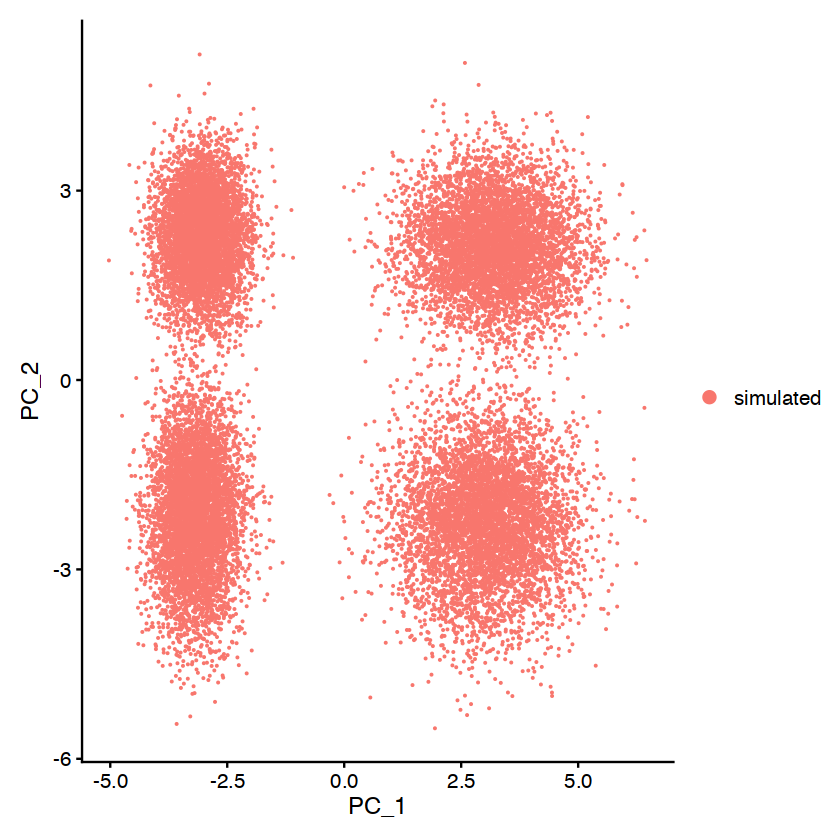

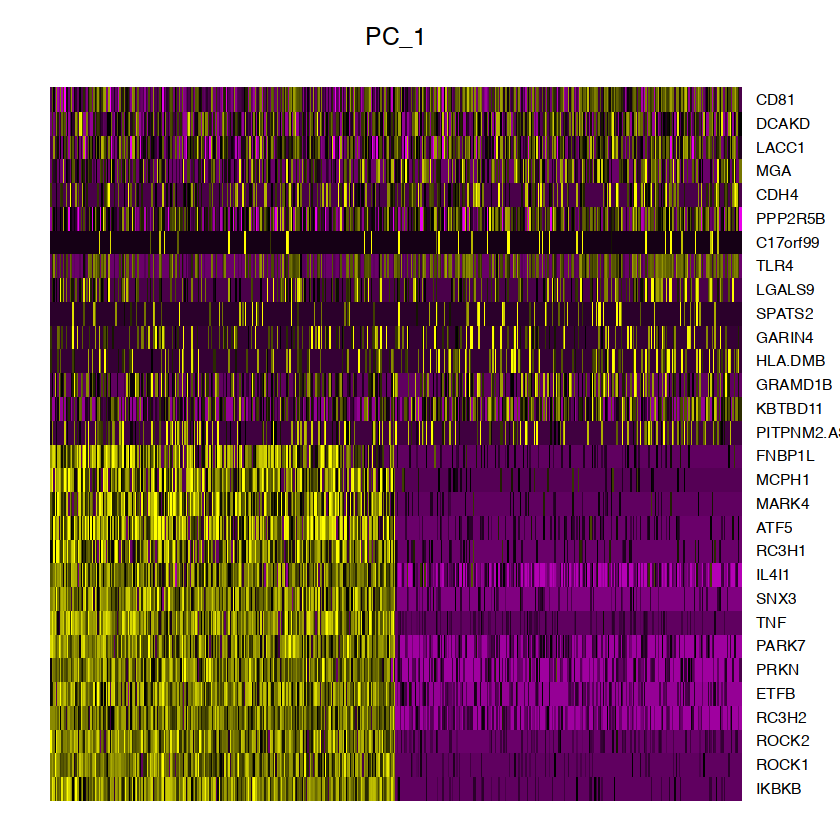

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 21676
Number of edges: 610612

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7465
Number of communities: 24
Elapsed time: 5 seconds


timepoint01.Cell1 timepoint01.Cell2 timepoint01.Cell3 timepoint01.Cell4 
               17                14                14                14 
timepoint01.Cell5 
                1 
Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
12:03:20 UMAP embedding parameters a = 0.9922 b = 1.112

12:03:20 Read 21676 rows and found 10 numeric columns

12:03:20 Using Annoy for neighbor search, n_neighbors = 30

12:03:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:03:23 Writing NN index file to temp file /var/folders/9l/qd8rzq0n5c52gphcs_p0dkg80000gn/T//Rtmpab1oU6/fileed9079ed45b9

12:03:23 Searching Annoy index using 1 thread, search_k = 3000

12:03:35 Annoy recall = 100%

12:03:35 Commencing smooth kNN distance calibra

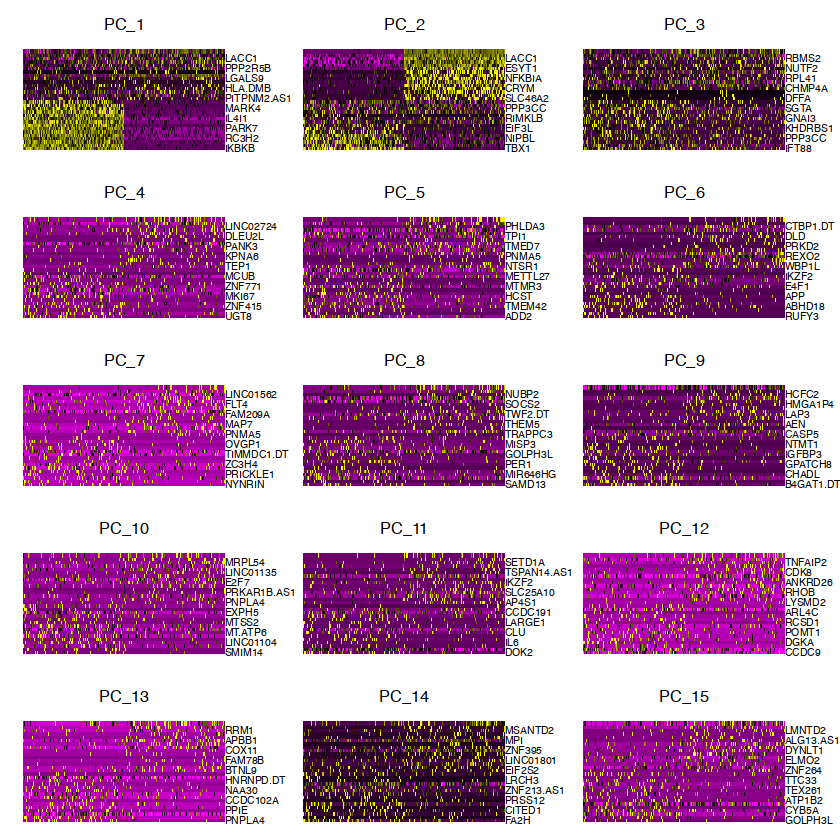

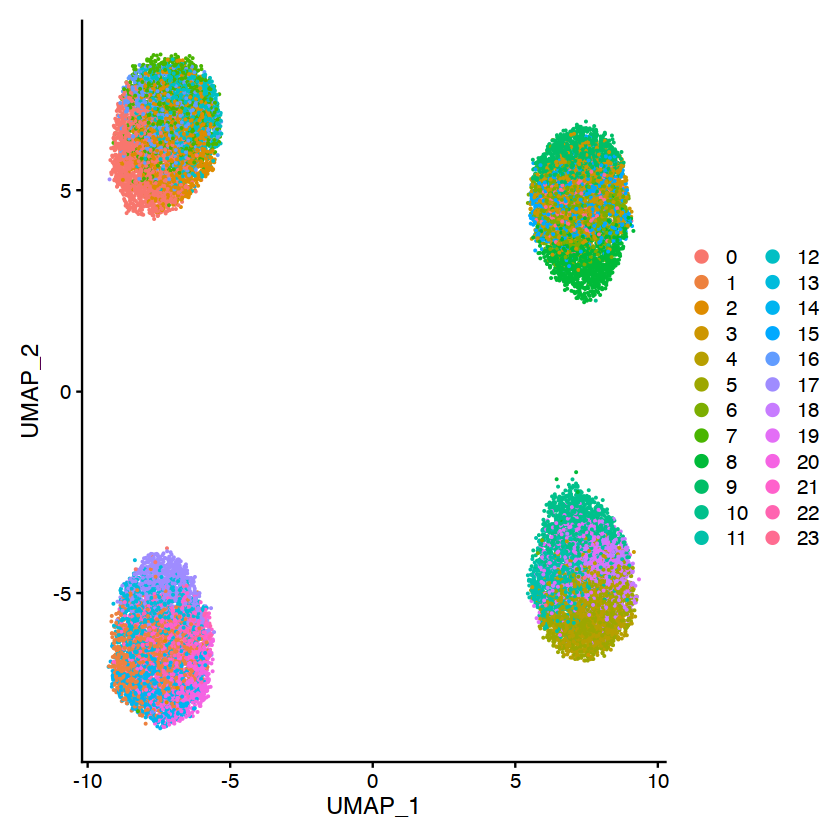

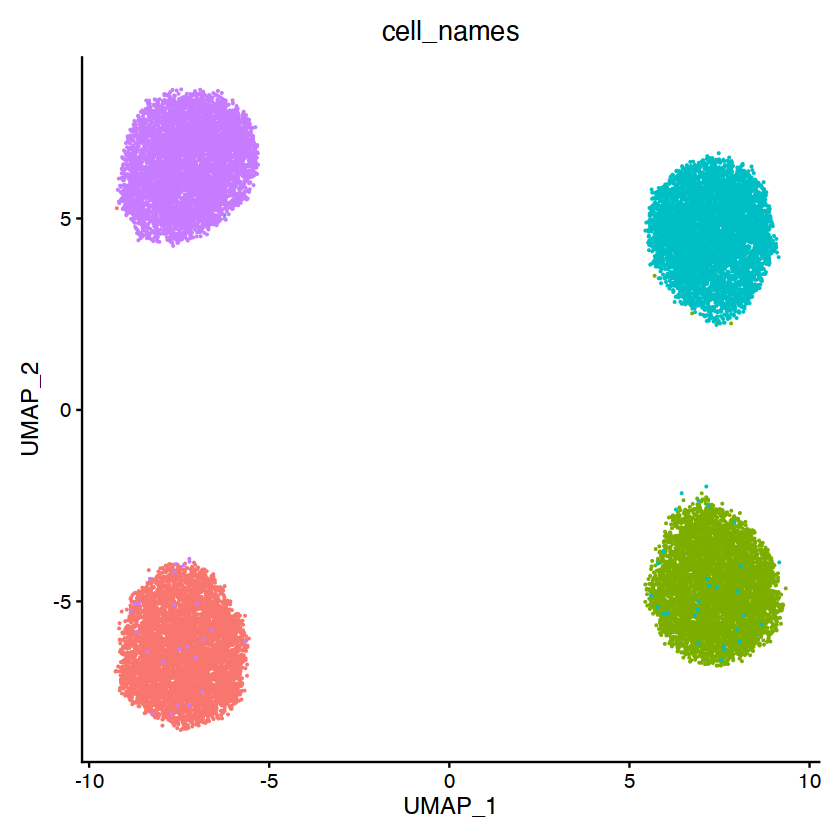

In [13]:

rownames(sim_result$count_matrix)=make.names(rownames(sim_result$count_matrix))
colnames(sim_result$count_matrix)=make.names(colnames(sim_result$count_matrix))

sObject <- CreateSeuratObject(counts = sim_result$count_matrix, project = "simulated", min.cells = 0, min.features = 200)
sObject[["percent.mt"]] <- PercentageFeatureSet(sObject, pattern = "^MT-")

VlnPlot(sObject, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
plot1 <- FeatureScatter(sObject, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(sObject, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2
sObject <- NormalizeData(sObject, normalization.method = "LogNormalize", scale.factor = 10000)
sObject <- FindVariableFeatures(sObject, selection.method = "vst", nfeatures = 2000)
top10 <- head(VariableFeatures(sObject), 10)
# plot variable features with and without labels
plot1 <- VariableFeaturePlot(sObject)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

all.genes <- rownames(sObject)
sObject <- ScaleData(sObject, features = all.genes)

sObject <- RunPCA(sObject, features = VariableFeatures(object = sObject))
print(sObject[["pca"]], dims = 1:5, nfeatures = 5)
VizDimLoadings(sObject, dims = 1:2, reduction = "pca")
DimPlot(sObject, reduction = "pca")

DimHeatmap(sObject, dims = 1, cells = 500, balanced = TRUE)
DimHeatmap(sObject, dims = 1:15, cells = 500, balanced = TRUE)
sObject <- FindNeighbors(sObject, dims = 1:5)
sObject <- FindClusters(sObject, resolution = 2)
head(Idents(sObject), 5)

sObject <- RunUMAP(sObject, dims = 1:10)
DimPlot(sObject, reduction = "umap")

sObject[["cell_names"]] <- condition_vector
DimPlot(sObject, group.by = "cell_names") + NoLegend()

In [14]:
source("https://raw.githubusercontent.com/mjoppich/FlowSets/main/seurat_util_functions.R")
saveRDS(sObject, file = "simulated_scdata_random.rds")


summarised_data=getExtendedExpressionData(sObject,group.by="cell_names")

write.table(summarised_data,file = "summarised_simulated_scdata_random.tsv",sep="\t",row.names = FALSE,col.names=TRUE,quote = FALSE)

write.table(intensity_matrix[unlist(apply(intensity_matrix,1, sd, na.rm = TRUE))!=0, ],file = "simulated_changingGenes_random.tsv",sep="\t",row.names = TRUE,col.names=TRUE,quote = FALSE)



Attache Paket: 'data.table'


Die folgenden Objekte sind maskiert von 'package:dplyr':

    between, first, last



Attache Paket: 'purrr'


Das folgende Objekt ist maskiert 'package:data.table':

    transpose




[1] "cell_names"
[1] "timepoint01"


as(<dgCMatrix>, "dgTMatrix") is deprecated since Matrix 1.5-0; do as(., "TsparseMatrix") instead



[1] "timepoint02"
[1] "timepoint03"
[1] "timepoint04"


In [15]:
trends

[[1]]
[1] 1 1 4 4

[[2]]
[1] 1 8 8 1

[[3]]
[1] 2 2 1 1

[[4]]
[1] 3 3 3 3

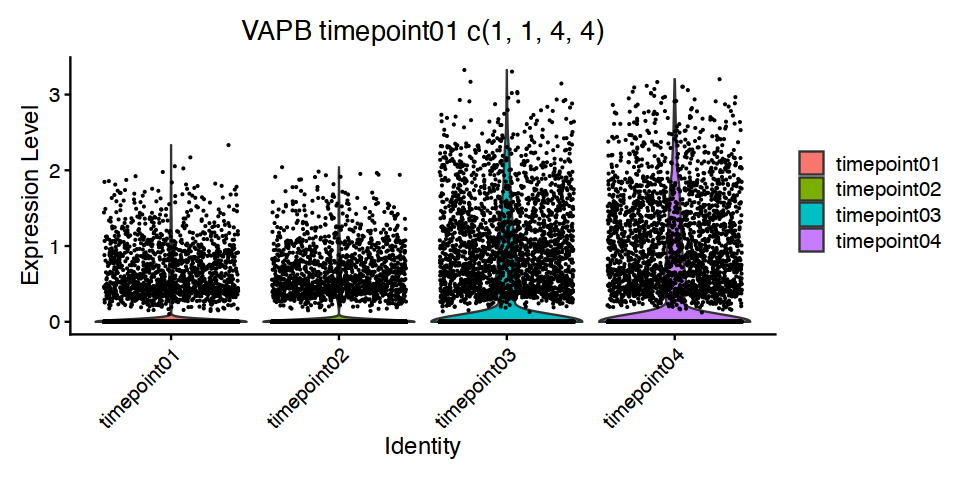

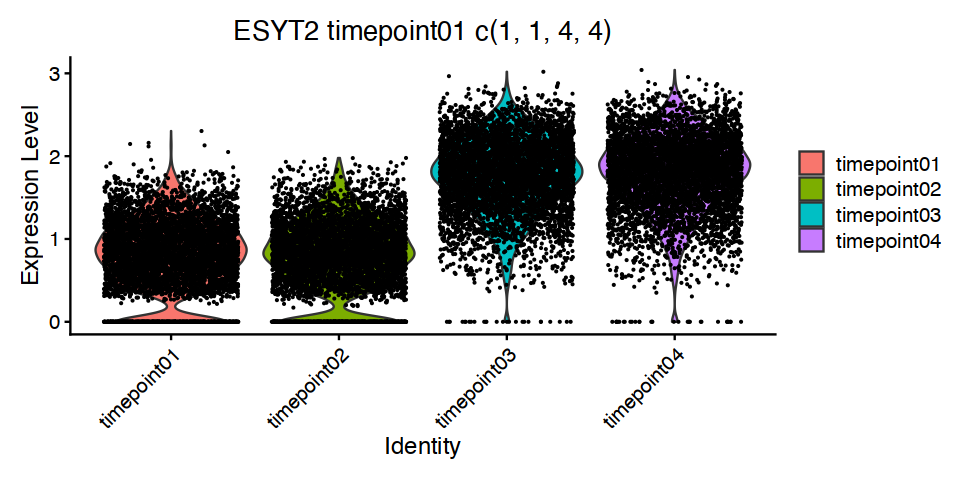

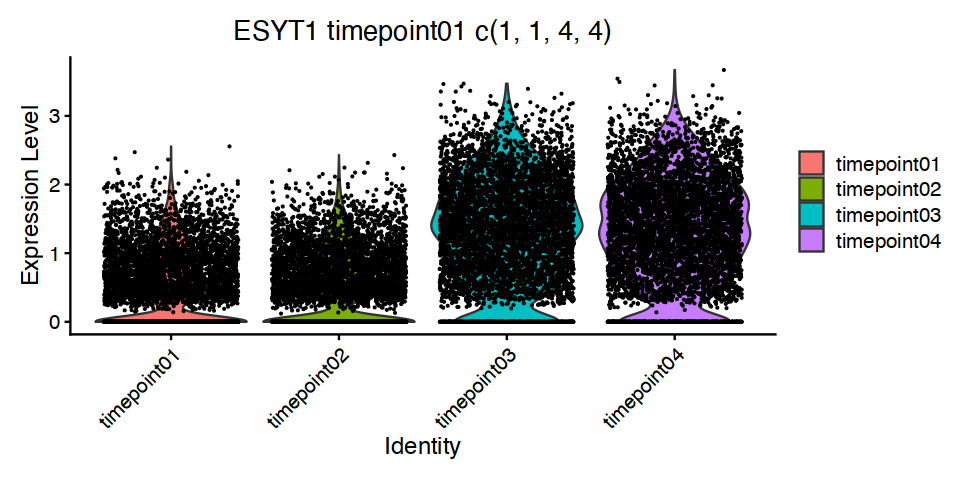

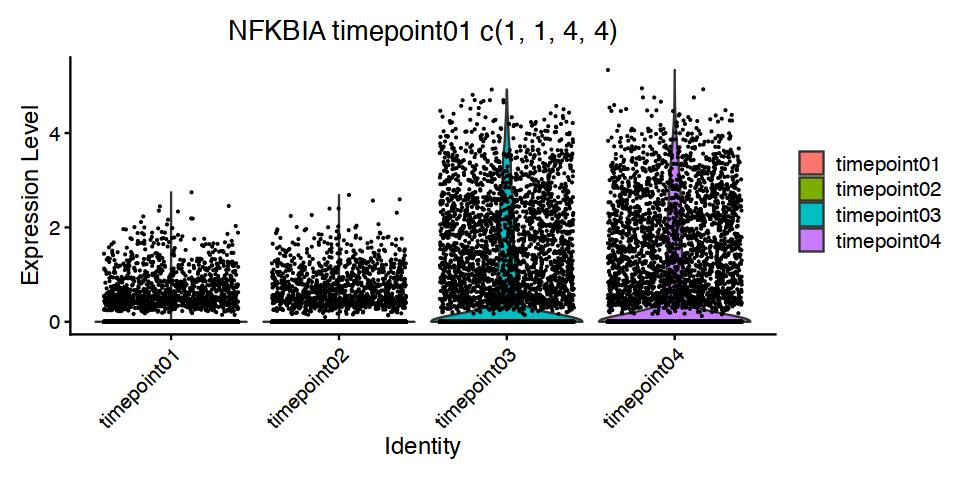

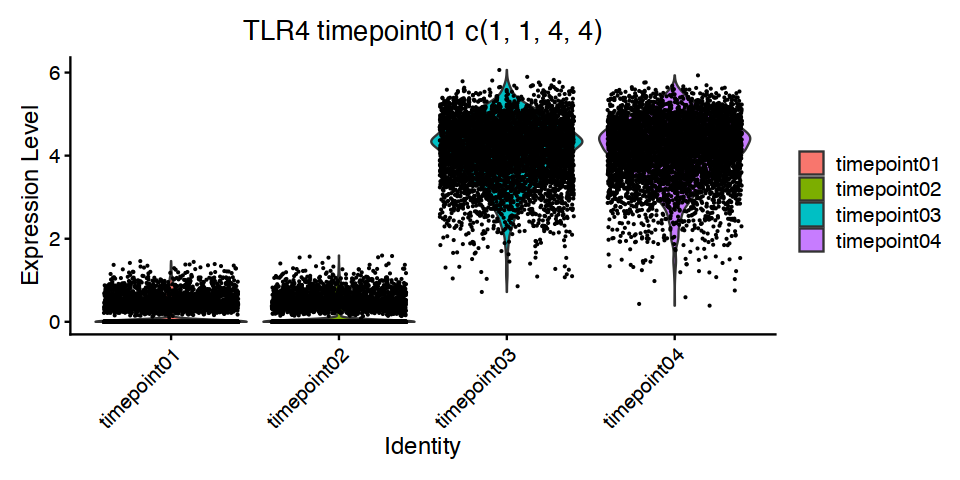

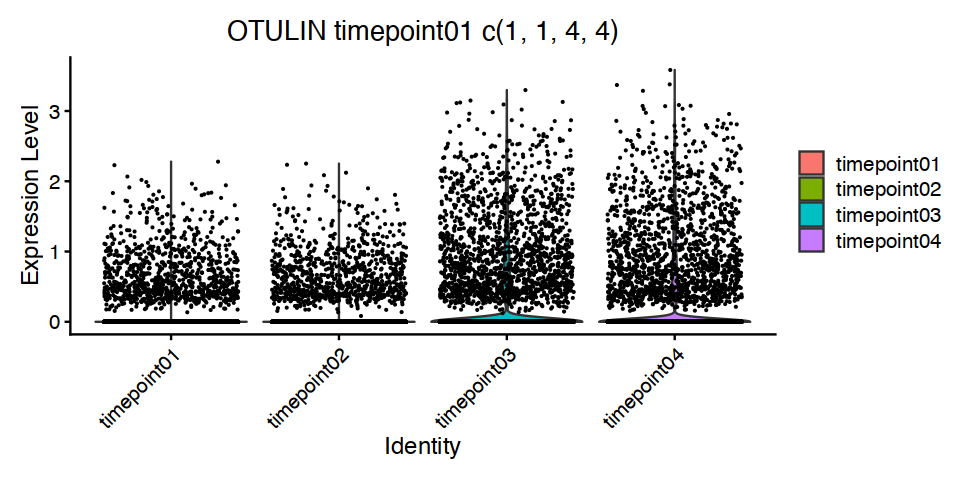

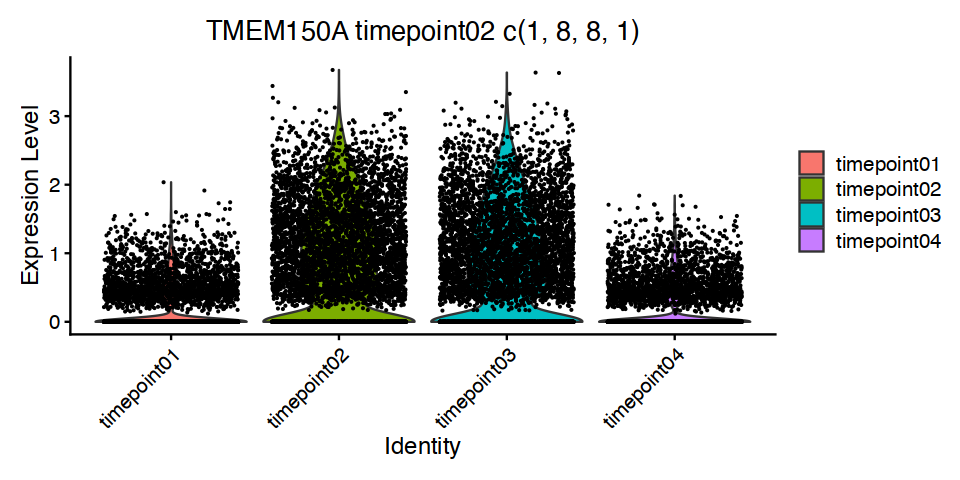

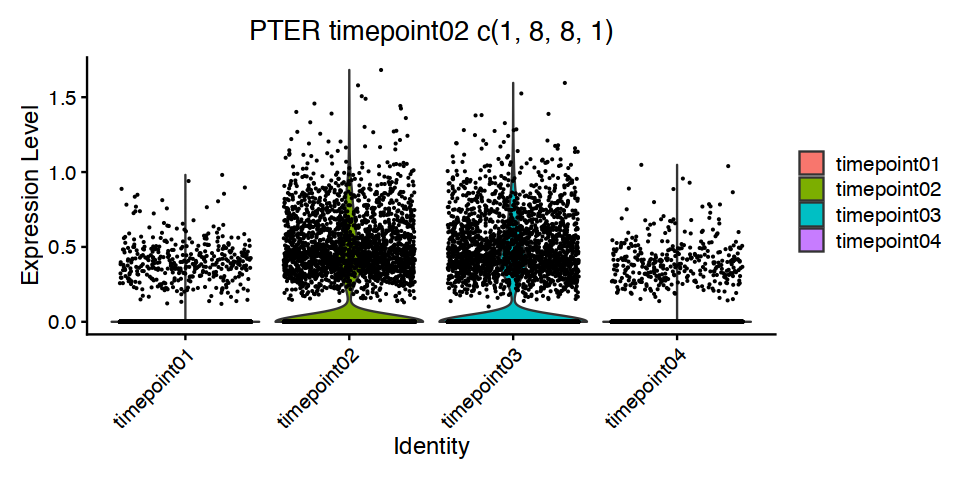

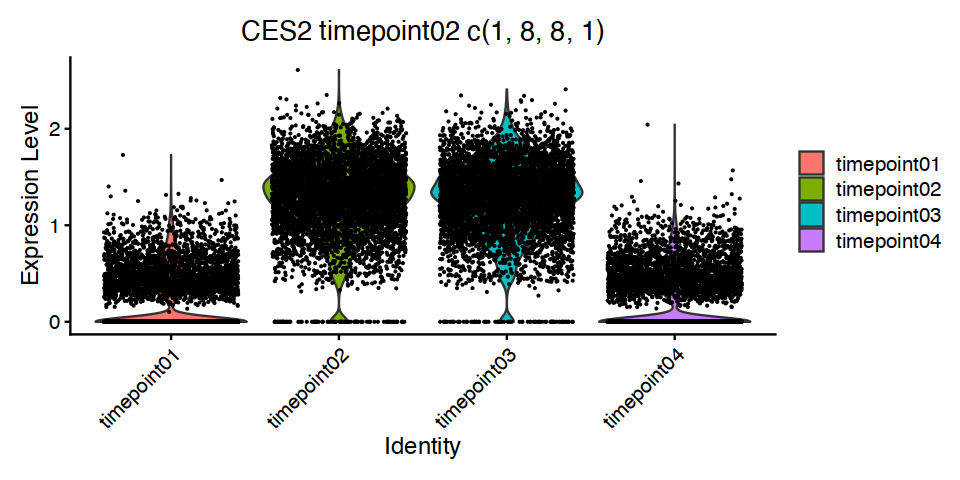

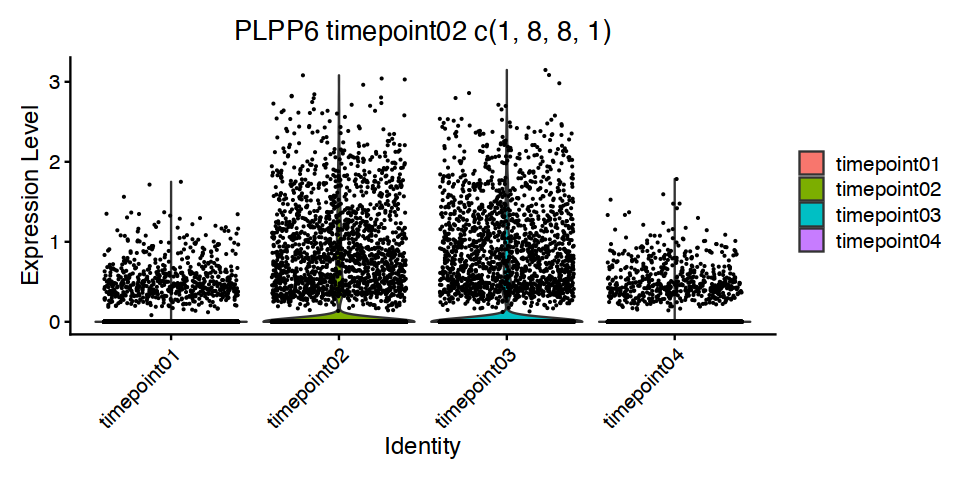

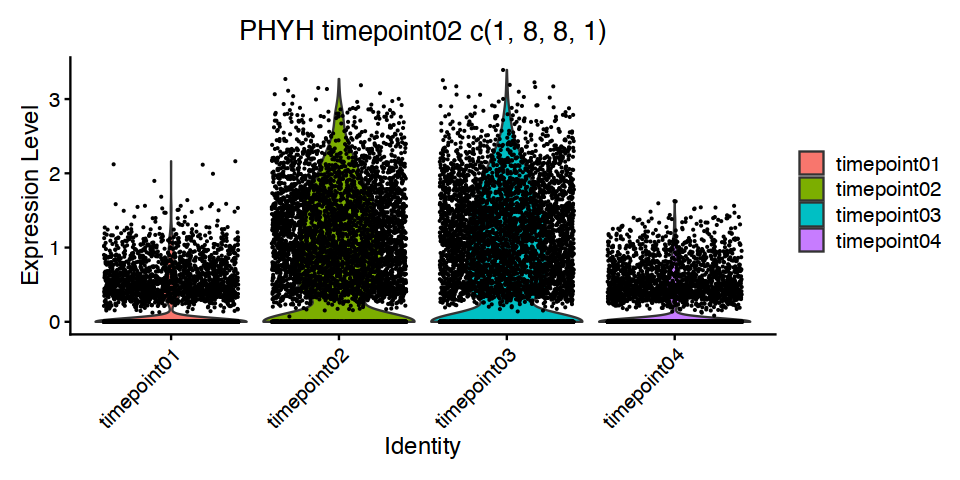

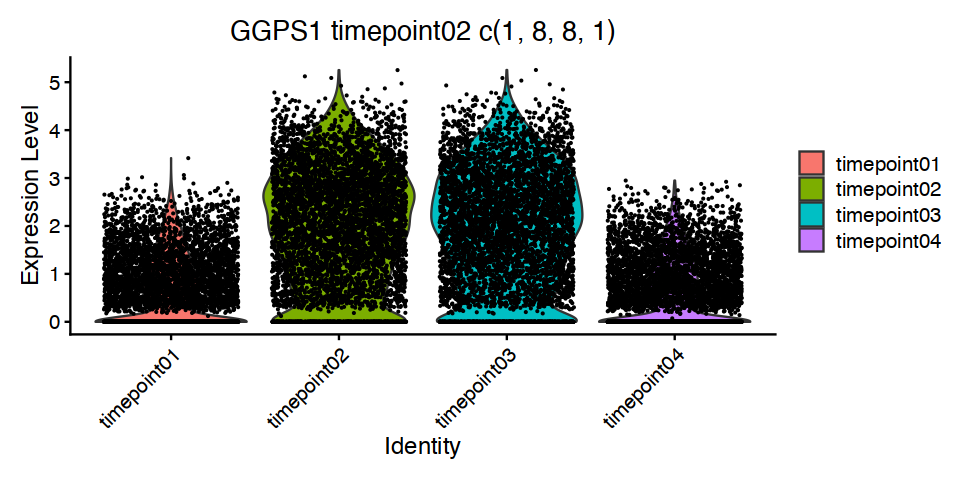

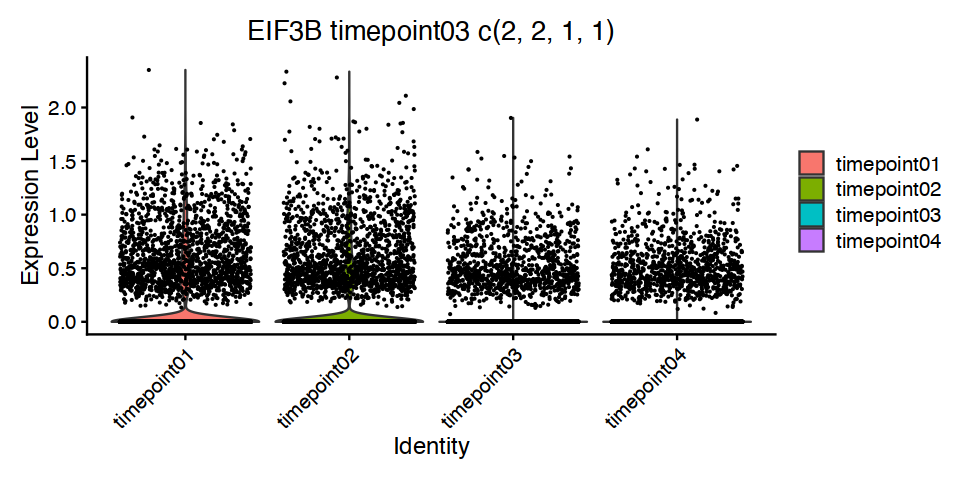

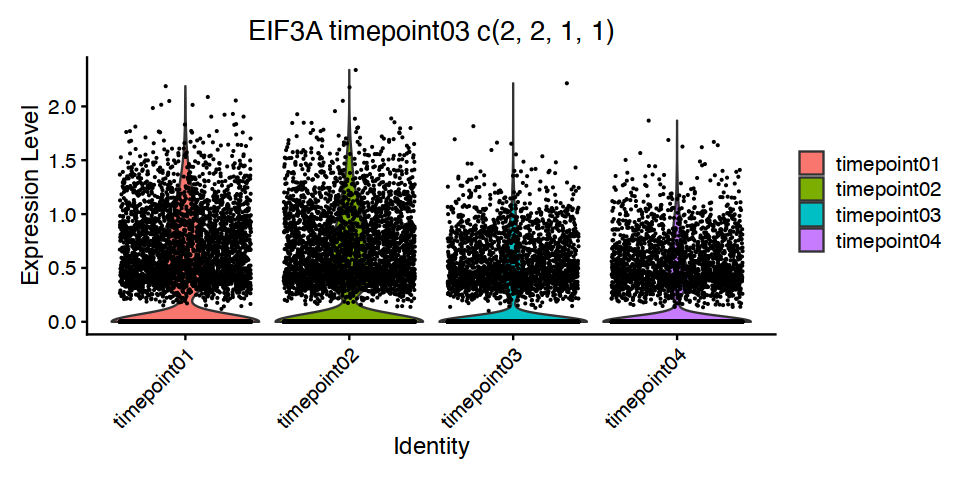

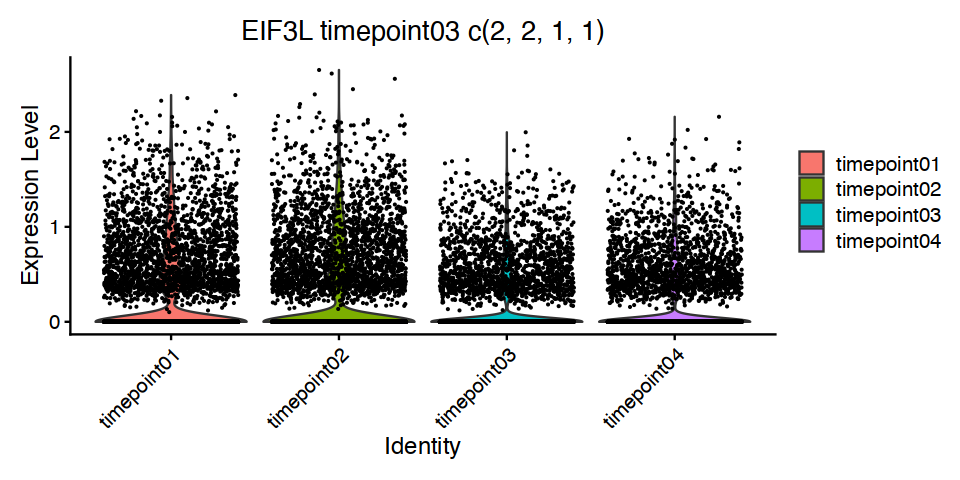

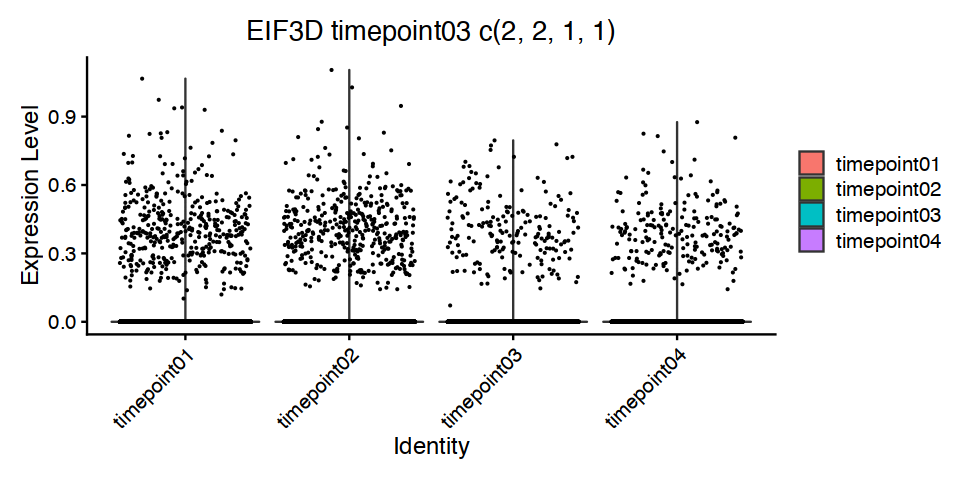

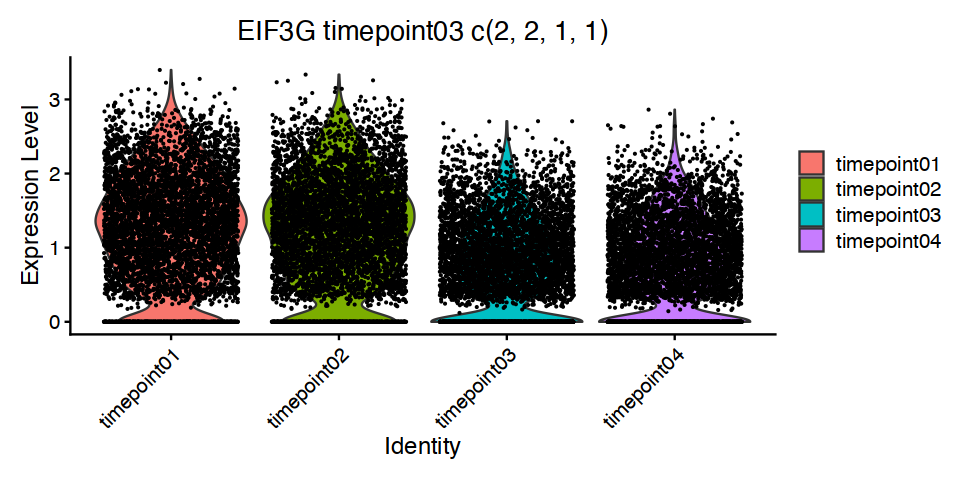

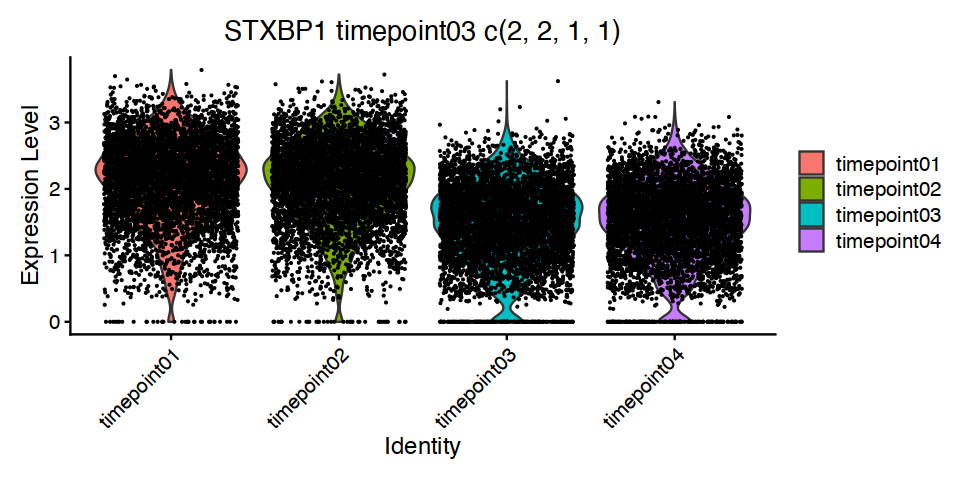

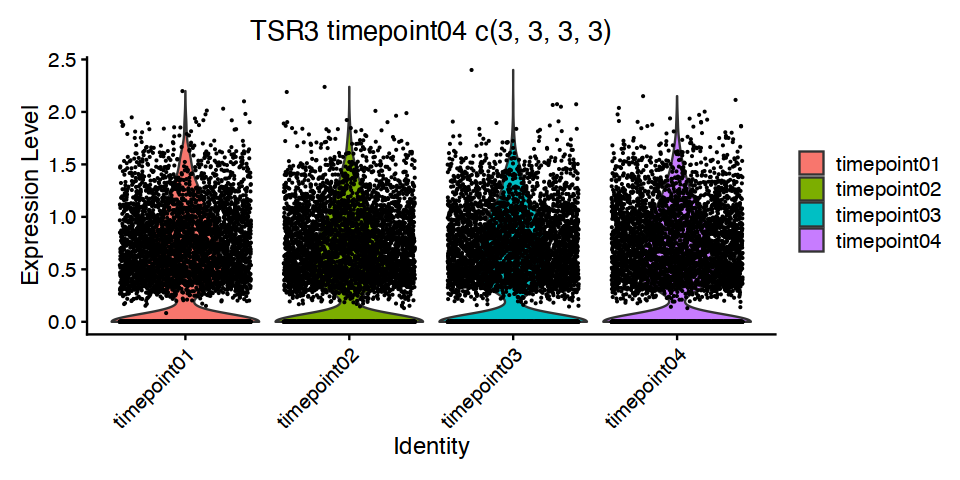

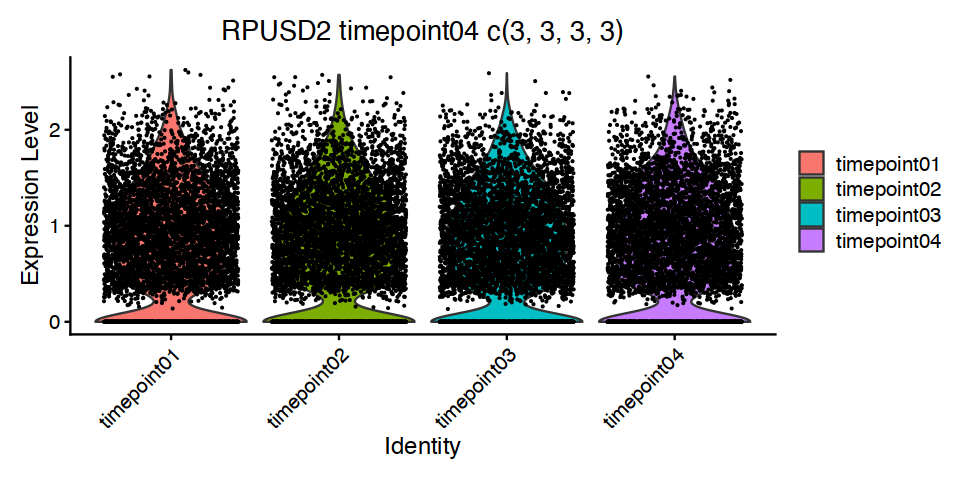

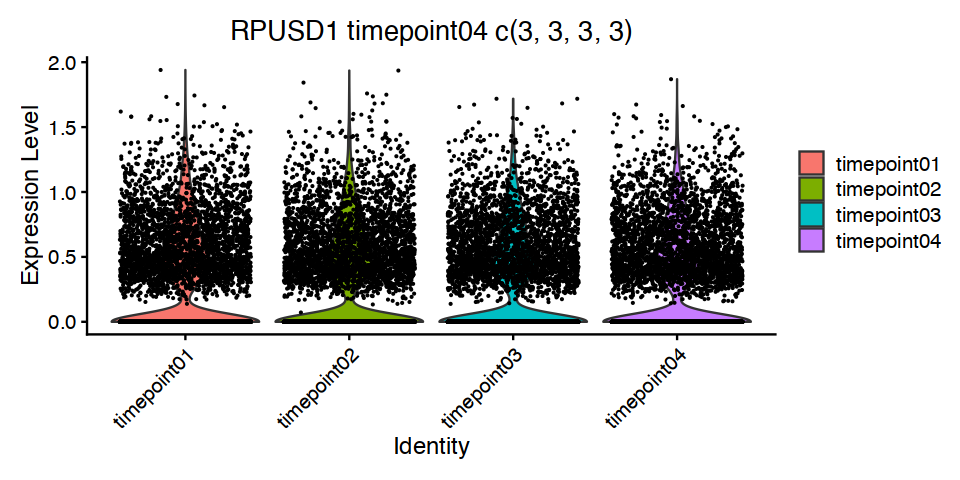

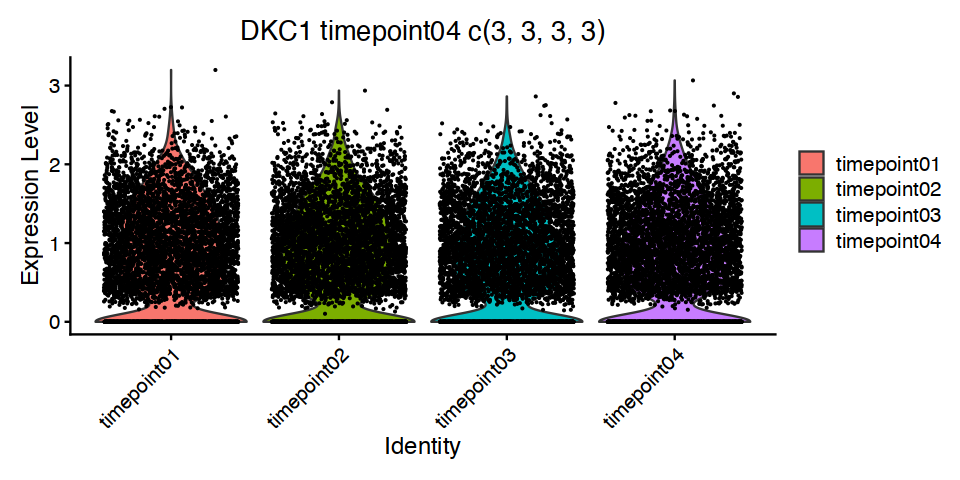

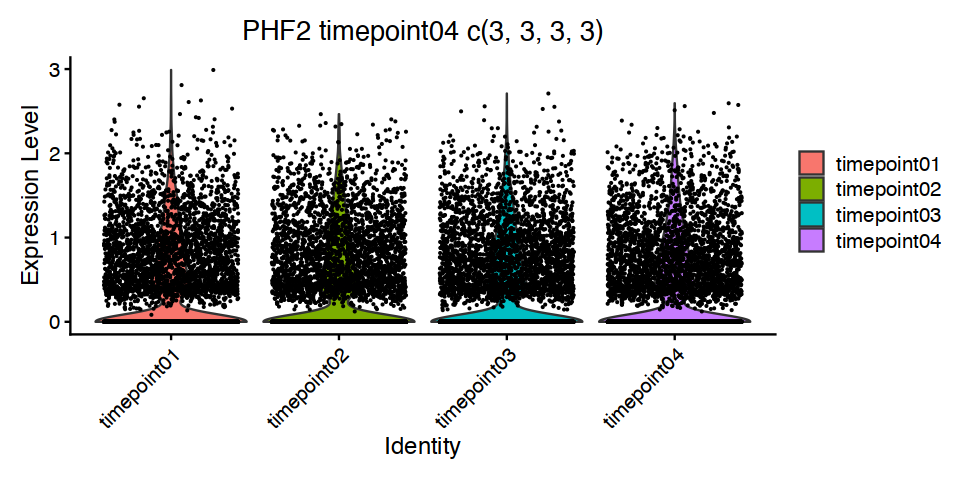

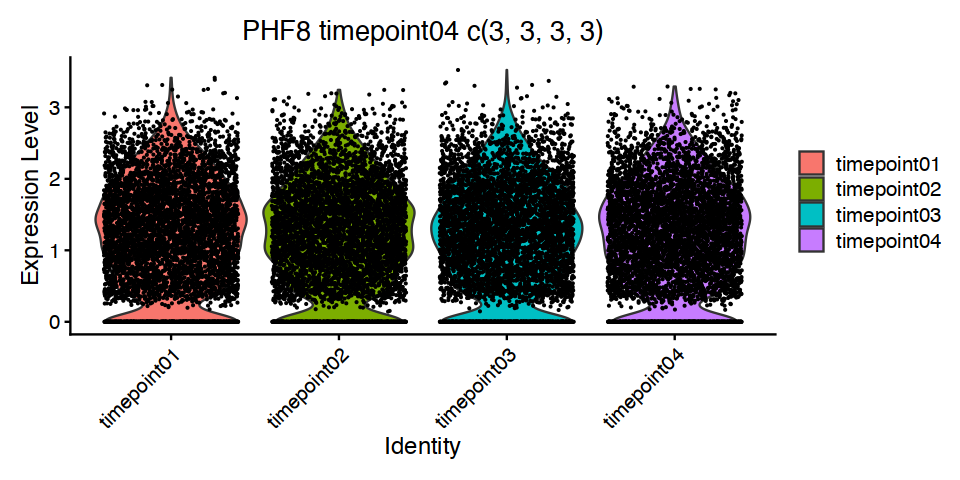

In [16]:
options(repr.plot.width = 8, repr.plot.height = 4)

for (stateindex in 1:length(states))
{
    state = names(state2genes)[stateindex]
    trend = trends[stateindex]
    plotnamesuffix = paste(state, paste(trend, sep="->"))

    for (gene in head(state2genes[[state]]))
    {
        gene = make.names(gene)
        p=VlnPlot(sObject, gene, group.by="cell_names") + ggtitle(paste(gene, plotnamesuffix))
        plot(p)

    }

}